In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline
import time, sys
from scipy.sparse import spdiags
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
import pickle
from scipy.io import savemat, loadmat
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load weights and bias
file_name_AE="./model/AE_v2_swish.p"

AE = pickle.load(open(file_name_AE,'rb'))

en_w1=AE['en_w1']
en_b1=AE['en_b1']
en_w2=AE['en_w2']
de_w1=AE['de_w1']
de_w2=AE['de_w2']
de_w1T=AE['de_w1T']
de_w2T=AE['de_w2T']
de_w2_sp=AE['de_w2_sp']
de_w2T_sp=AE['de_w2T_sp']

m, M2 = de_w2.shape
f = de_w1.shape[1]

In [3]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def decoder_np_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)  
    return y

def decoder_np_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = de_w2.dot(a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = dout.dot(de_w2T)   
    return y,dydxT.T

def decoder_sp_forward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)
    return y

def decoder_sp_forward_backward(x):
    z1 = de_w1.dot(x)
    s1 = sigmoid_np(z1)
    a1 = z1*s1
    y = sp.csr_matrix.dot(de_w2_sp,a1)

    dout = de_w1T
    dout = (s1 + a1*(1-s1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_w2T_sp)
    return y,dydxT.T

In [4]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

In [5]:
def residual_lspg_hr(uwn_z,g,z0_ind,z1_ind,c):
    
    # g is subnet of g
    # Jg is subnet of Jg
    # z_union[z0_ind] gives z0, which is z
    # z_union[z1_ind] igves z1, which is z-1
    
    r = -uwn_z + g[z0_ind] + c*(g[z0_ind]**2 - g[z0_ind]*g[z1_ind])
    
    return r

def jacobian_lspg_hr(g,Jg,z0_ind,z1_ind,c):
    
    J = ((1.0 + c*(2*g[z0_ind] - g[z1_ind]))*Jg[z0_ind].T).T + (-c*g[z0_ind]*Jg[z1_ind].T).T
    
    return J

In [6]:
# load snapshot
snapshot_full=pickle.load(open('./data/snapshot_full.p','rb'))
DEIM_snapshot=snapshot_full[:,:-1]

# Do SVD
# Ur,Sr,VrT=np.linalg.svd(DEIM_snapshot.T,full_matrices=False)
# SVD={'Ur':Ur,'Sr':Sr,'VrT':VrT}
# pickle.dump(SVD,open('./model/NMROM_residual_basis.p','wb'))
SVD=pickle.load(open('./model/NMROM_residual_basis.p','rb'))
Ur=SVD['Ur']
# plt.figure()
# plt.semilogy(Sr)
# plt.show()

In [10]:
# load results
resultArr=pickle.load(open('./data/prediction_NM-LSPG-HR.p','rb'))
resultArr_append=pickle.load(open('./data/prediction_NM-LSPG-HR_append.p','rb'))
resultArr=np.vstack((resultArr_append,resultArr))


amp=0.6

# of residual basis: 46
# of residual sampes: 48

Time elapsed: 0.595999002456665 sec
average relative error: 3.5312327614843007%
maximum relative error: 4.99653161577427%


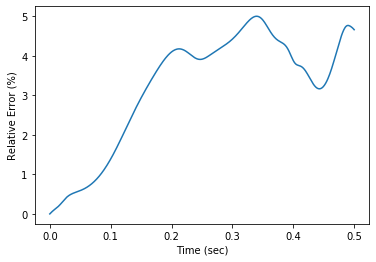


------------------------------------------------------------------------

amp=0.62

# of residual basis: 37
# of residual sampes: 39

Time elapsed: 0.5980017185211182 sec
average relative error: 2.687665040645839%
maximum relative error: 4.251551482840108%


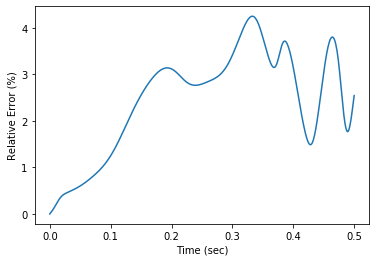


------------------------------------------------------------------------

amp=0.64

# of residual basis: 37
# of residual sampes: 39

Time elapsed: 0.6180005073547363 sec
average relative error: 2.4852969089209047%
maximum relative error: 3.864721735342268%


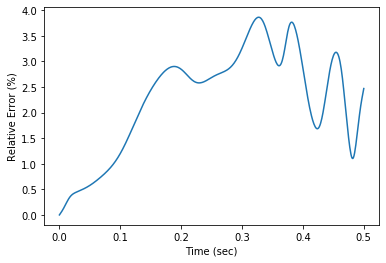


------------------------------------------------------------------------

amp=0.66

# of residual basis: 44
# of residual sampes: 46

Time elapsed: 0.679002046585083 sec
average relative error: 2.6721970674737765%
maximum relative error: 3.770418574195017%


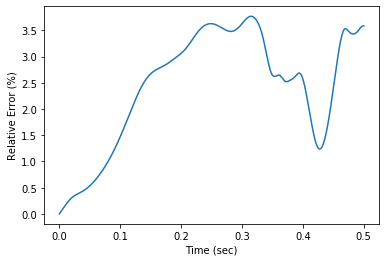


------------------------------------------------------------------------

amp=0.68

# of residual basis: 42
# of residual sampes: 44

Time elapsed: 0.6380002498626709 sec
average relative error: 2.2128948736671292%
maximum relative error: 3.4215989911764626%


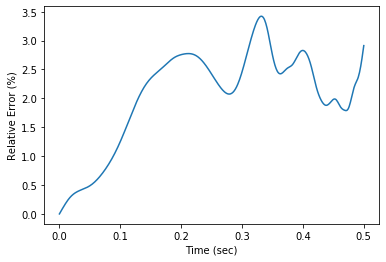


------------------------------------------------------------------------

amp=0.7

# of residual basis: 42
# of residual sampes: 44

Time elapsed: 0.6419987678527832 sec
average relative error: 1.9483062817092551%
maximum relative error: 2.945870919921471%


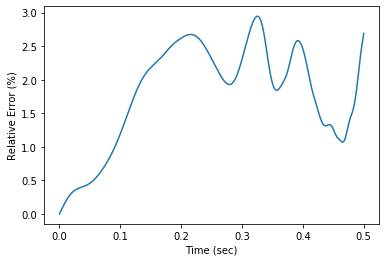


------------------------------------------------------------------------

amp=0.72

# of residual basis: 42
# of residual sampes: 44

Time elapsed: 0.6169998645782471 sec
average relative error: 1.7784453609319213%
maximum relative error: 2.7219748051154213%


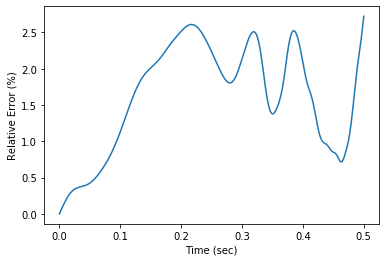


------------------------------------------------------------------------

amp=0.74

# of residual basis: 42
# of residual sampes: 44

Time elapsed: 0.620002031326294 sec
average relative error: 1.7186672991936343%
maximum relative error: 2.8893794954693344%


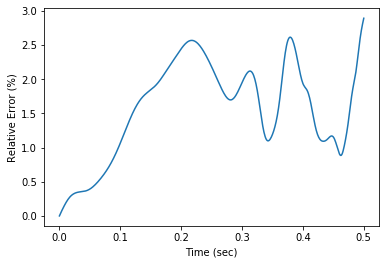


------------------------------------------------------------------------

amp=0.76

# of residual basis: 43
# of residual sampes: 45

Time elapsed: 0.6860024929046631 sec
average relative error: 1.6343748430661842%
maximum relative error: 2.7434540983694955%


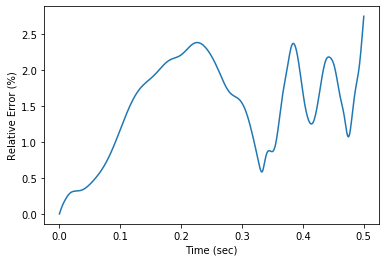


------------------------------------------------------------------------

amp=0.78

# of residual basis: 36
# of residual sampes: 45

Time elapsed: 0.6119997501373291 sec
average relative error: 1.2862590294933502%
maximum relative error: 2.467262614634075%


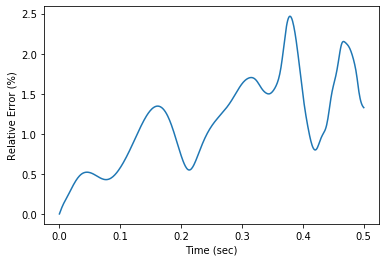


------------------------------------------------------------------------

amp=0.8

# of residual basis: 38
# of residual sampes: 47

Time elapsed: 0.6110000610351562 sec
average relative error: 1.2931885252827853%
maximum relative error: 2.0896683452730884%


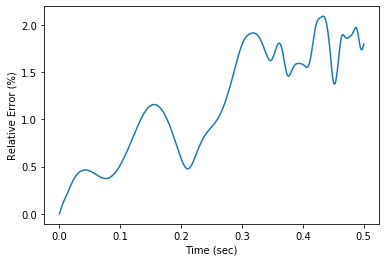


------------------------------------------------------------------------

amp=0.82

# of residual basis: 38
# of residual sampes: 47

Time elapsed: 0.6560001373291016 sec
average relative error: 0.9304348155091026%
maximum relative error: 1.5098961337961088%


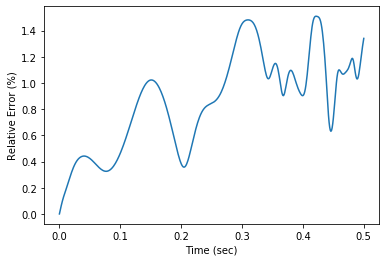


------------------------------------------------------------------------

amp=0.84

# of residual basis: 38
# of residual sampes: 47

Time elapsed: 0.6230006217956543 sec
average relative error: 0.7226748401589363%
maximum relative error: 1.3155223872645294%


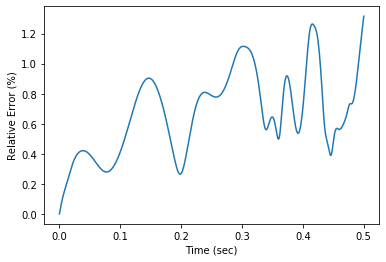


------------------------------------------------------------------------

amp=0.86

# of residual basis: 38
# of residual sampes: 47

Time elapsed: 0.5969998836517334 sec
average relative error: 0.6758490920726543%
maximum relative error: 1.543424004699092%


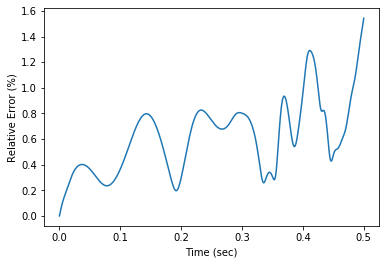


------------------------------------------------------------------------

amp=0.88

# of residual basis: 37
# of residual sampes: 46

Time elapsed: 0.593003511428833 sec
average relative error: 0.6997046712342577%
maximum relative error: 1.3974029443407554%


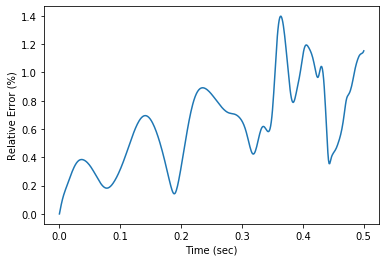


------------------------------------------------------------------------

amp=0.9

# of residual basis: 33
# of residual sampes: 33

Time elapsed: 0.5910048484802246 sec
average relative error: 0.8600793490521154%
maximum relative error: 1.3531113950462388%


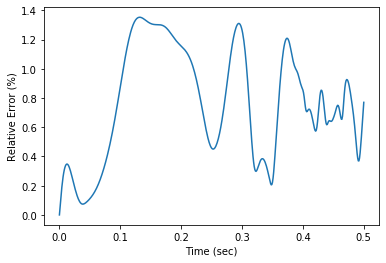


------------------------------------------------------------------------

amp=0.92

# of residual basis: 33
# of residual sampes: 33

Time elapsed: 0.5810003280639648 sec
average relative error: 0.7198498941715705%
maximum relative error: 1.172063850404525%


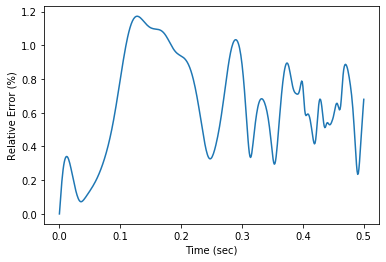


------------------------------------------------------------------------

amp=0.94

# of residual basis: 33
# of residual sampes: 33

Time elapsed: 0.5660204887390137 sec
average relative error: 0.6286825845751809%
maximum relative error: 0.9966143169017856%


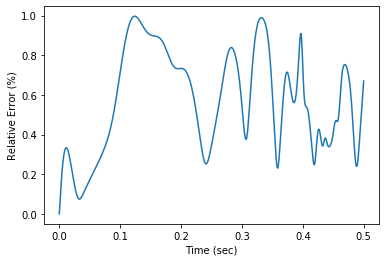


------------------------------------------------------------------------

amp=0.96

# of residual basis: 33
# of residual sampes: 33

Time elapsed: 0.5549988746643066 sec
average relative error: 0.622839354936545%
maximum relative error: 1.2913536964911627%


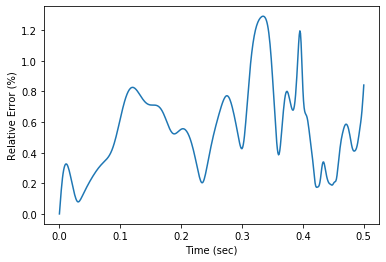


------------------------------------------------------------------------

amp=0.98

# of residual basis: 31
# of residual sampes: 47

Time elapsed: 0.5680022239685059 sec
average relative error: 0.44091806552159096%
maximum relative error: 1.3278285187818168%


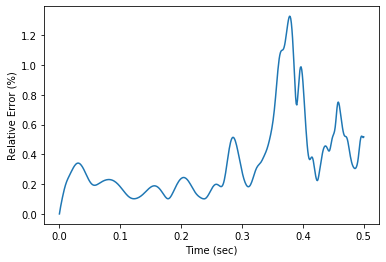


------------------------------------------------------------------------

amp=1.0

# of residual basis: 31
# of residual sampes: 47

Time elapsed: 0.5879988670349121 sec
average relative error: 0.4232336847397736%
maximum relative error: 1.034815335757936%


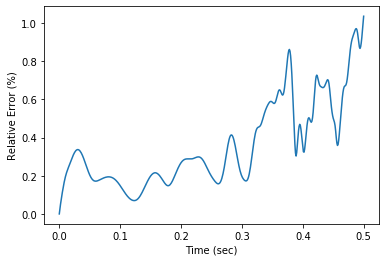


------------------------------------------------------------------------

amp=1.02

# of residual basis: 33
# of residual sampes: 49

Time elapsed: 0.6270027160644531 sec
average relative error: 0.2842055286556862%
maximum relative error: 0.6238954741059912%


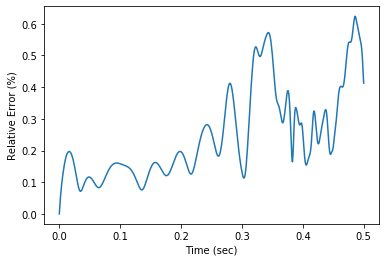


------------------------------------------------------------------------

amp=1.04

# of residual basis: 31
# of residual sampes: 48

Time elapsed: 0.6220006942749023 sec
average relative error: 0.6639247034568659%
maximum relative error: 1.3021577995536004%


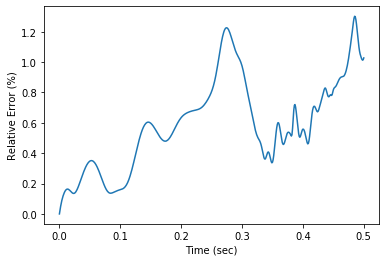


------------------------------------------------------------------------

amp=1.06

# of residual basis: 30
# of residual sampes: 48

Time elapsed: 0.6230015754699707 sec
average relative error: 0.7696161551974012%
maximum relative error: 1.5758183373676387%


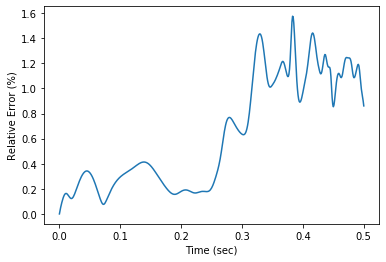


------------------------------------------------------------------------

amp=1.08

# of residual basis: 33
# of residual sampes: 39

Time elapsed: 0.6160018444061279 sec
average relative error: 0.6932721597624039%
maximum relative error: 1.4040371905591877%


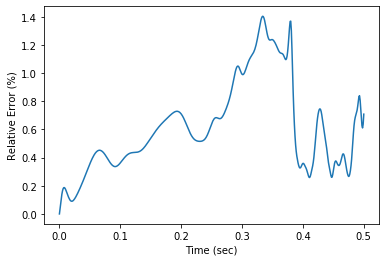


------------------------------------------------------------------------

amp=1.1

# of residual basis: 33
# of residual sampes: 40

Time elapsed: 0.6270005702972412 sec
average relative error: 0.7485232691244379%
maximum relative error: 1.47731595086975%


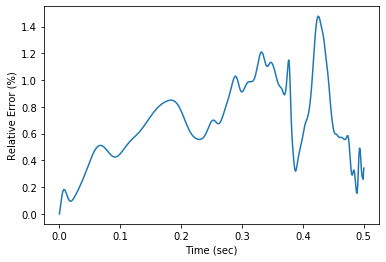


------------------------------------------------------------------------

amp=1.12

# of residual basis: 33
# of residual sampes: 42

Time elapsed: 0.6560027599334717 sec
average relative error: 1.0383107505302993%
maximum relative error: 1.5104534925323827%


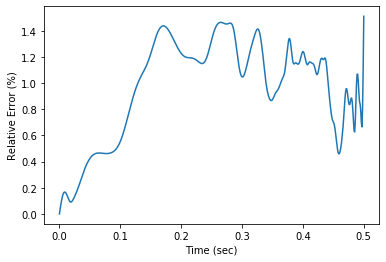


------------------------------------------------------------------------

amp=1.14

# of residual basis: 44
# of residual sampes: 49

Time elapsed: 0.7120046615600586 sec
average relative error: 1.0989580166237976%
maximum relative error: 2.7648653731837043%


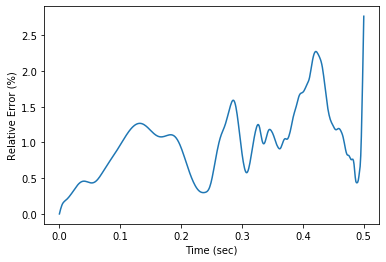


------------------------------------------------------------------------

amp=1.16

# of residual basis: 31
# of residual sampes: 48

Time elapsed: 0.6569986343383789 sec
average relative error: 2.615095885647654%
maximum relative error: 4.065070057587156%


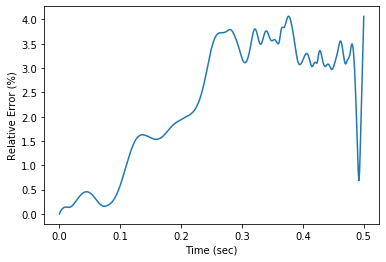


------------------------------------------------------------------------

amp=1.18

# of residual basis: 31
# of residual sampes: 48

Time elapsed: 0.623004674911499 sec
average relative error: 3.003043950212366%
maximum relative error: 5.429364946465713%


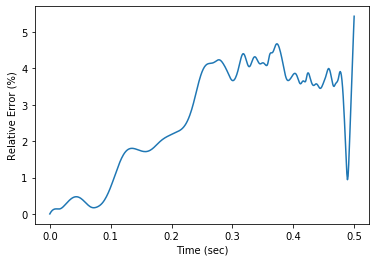


------------------------------------------------------------------------

amp=1.2

# of residual basis: 44
# of residual sampes: 48

Time elapsed: 0.7370011806488037 sec
average relative error: 2.576223711715848%
maximum relative error: 6.66006347208236%


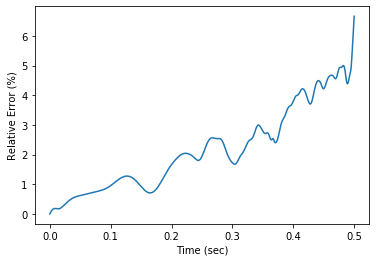


------------------------------------------------------------------------


In [11]:
ampArr = resultArr[:,0]
num_amp=ampArr.shape[0]
resultArrNew=np.zeros((num_amp,6))

for iii in range(num_amp):
    # load FOM solution
    amp=ampArr[iii]
    print()
    print('amp={}'.format(amp))
    file_name_FOM="./data/FOM_amp_{}.p".format(amp)
    u=pickle.load(open(file_name_FOM,'rb'))
    
    # set parameters
    width = 1.0

    convergence_threshold = 1.0e-5
    maxk = 4

    nx = 1001
    dx = 2.0 / (nx - 1)
    nt = 500
    dt = 0.5 / nt  

    c = dt/dx

    x = np.linspace(0, 2, nx)

    idxn1=np.zeros(nx-1,dtype='int')
    idxn1[1:]=np.arange(nx-2)
    idxn1[0]=nx-2

    u0 = np.copy(u[0])
    u_hat0=np.zeros(f,dtype='float32')
    
    # choose # of DEIM basis and DEIM samples
    DEIM_basis=int(resultArr[iii,1])
    DEIM_samples=int(resultArr[iii,2])
    print()
    print('# of residual basis: {}'.format(DEIM_basis))
    print('# of residual sampes: {}'.format(DEIM_samples))

    # precompute
    phi_r=Ur[:,:DEIM_basis]
    z=DEIM(phi_r,DEIM_samples)
    ZT=np.eye(nx-1,dtype='float32')[z]
    Z=ZT.T
    precomp1=phi_r@np.linalg.pinv(ZT@phi_r)
    precomp=precomp1.T@precomp1

    # influential indices
    z_union=np.zeros((z.size,2),dtype='int')
    for i in range(z.size):
        if z[i]==0:
            z_union[i,0]=0
            z_union[i,1]=nx-2
        else:
            z_union[i,0]=z[i]
            z_union[i,1]=z[i]-1        
    z0=z_union[:,0]
    z1=z_union[:,1]

    z_union=np.unique(z_union.flatten())

    z_union0_ind=np.zeros(z0.size,dtype='int')
    z_union1_ind=np.zeros(z1.size,dtype='int')
    for i in range(z0.size):
        z_union0_ind[i]=np.nonzero(np.isin(z_union,z0[i]))[0]
        z_union1_ind[i]=np.nonzero(np.isin(z_union,z1[i]))[0]

    # Construct subnet
    class DecoderFC(nn.Module):

        def __init__(self,):
            super(DecoderFC, self).__init__()
            self.fc1 = nn.Linear(f,M2,bias=False)
            self.fc1.weight = nn.Parameter(torch.ones(de_w1.shape))
    #         self.fc1.weight = nn.Parameter(torch.tensor(de_w1))

            self.fc2 = nn.Linear(M2,m,bias=False)
            self.fc2.weight = nn.Parameter(torch.ones(de_w2.shape))
    #         self.fc2.weight = nn.Parameter(torch.tensor(de_w2))

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            return x

    model = DecoderFC()

    x_in=torch.ones(f)
    y_out=model(x_in)

    p_hr=z_union

    upstream=torch.zeros_like(y_out)
    upstream[p_hr]=1.0

    y_out.backward(upstream)

    # masks for subnet
    w1_mask=model.fc1.weight.grad
    w2_mask=model.fc2.weight.grad

    # subnet sparse weight
    idx1=w1_mask.to_sparse()._indices()
    i1=idx1.numpy()[0]
    j1=idx1.numpy()[1]
    v1=de_w1[i1,j1]
    w1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=w1_mask.shape).toarray())

    idx2=w2_mask.to_sparse()._indices()
    i2=idx2.numpy()[0]
    j2=idx2.numpy()[1]
    v2=de_w2[i2,j2]
    w2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=w2_mask.shape).toarray())

    # subnet compressed weight
    i1,j1,v1=sp.find(w1_sb_sp)
    i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
    i1_comp=np.arange(i1_unique.size)
    i1_comp=i1_comp[i1_inverse]
    j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
    j1_comp=np.arange(j1_unique.size)
    j1_comp=j1_comp[j1_inverse]
    w1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

    i2,j2,v2=sp.find(w2_sb_sp)
    i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
    i2_comp=np.arange(i2_unique.size)
    i2_comp=i2_comp[i2_inverse]
    j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
    j2_comp=np.arange(j2_unique.size)
    j2_comp=j2_comp[j2_inverse]
    w2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

    w1_sb_comp_dense=w1_sb_comp_sp.toarray()
    w1_sb_comp_dense=w1_sb_comp_dense[j2_unique]
    w2_sb_comp_dense=w2_sb_comp_sp.toarray()

    w1_sb_comp_denseT=w1_sb_comp_dense.T
    w2_sb_comp_denseT=w2_sb_comp_dense.T

    # Using sparse matrix
    w2_sb_comp_sp=sp.csr_matrix(w2_sb_comp_dense,dtype='float32')
    w2_sb_comp_spT=sp.csr_matrix(w2_sb_comp_denseT,dtype='float32')

    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def decoder_sb_np_forward(x):
        z1 = w1_sb_comp_dense.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = w2_sb_comp_dense.dot(a1)  
        return y

    def decoder_sb_np_forward_backward(x):
        z1 = w1_sb_comp_dense.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = w2_sb_comp_dense.dot(a1) 

        dout = w1_sb_comp_denseT
        dout = (a1 + s1*(1-a1))*dout
        dydxT = dout.dot(w2_sb_comp_denseT)
        return y,dydxT.T

    def decoder_sb_sp_forward(x):
        z1 = w1_sb_comp_dense.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)
        return y

    def decoder_sb_sp_forward_backward(x):
        z1 = w1_sb_comp_dense.dot(x)
        s1 = sigmoid_np(z1)
        a1 = z1*s1
        y = sp.csr_matrix.dot(w2_sb_comp_sp,a1)

        dout = w1_sb_comp_denseT
        dout = (a1 + s1*(1-a1))*dout
        dydxT = sp.csr_matrix.dot(dout,w2_sb_comp_spT)
        return y,dydxT.T

    # Run NM-ROM-DEIM
    t_total_rom_hr_start=time.time()

    u_rom_lspg_hr = np.zeros((nt+1,nx),dtype='float32')
    u_rom_lspg_hr[0] = u0.astype('float32')
    u_hat = np.zeros((nt+1,f),dtype='float32')
    u_hat[0] = u_hat0
    I_hat = np.eye(f,dtype='float32')
    for n in range(nt): 
    #     print("")
    #     print(n,"th time step:")

        u_hatw = u_hat[n].copy()

        uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
        uw += u0[z_union]

        J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
        J_lspgT = J_lspg.T

        r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
        r = J_lspgT.dot(precomp.dot(r_lspg))

        for k in range(maxk):   
            J = J_lspgT@precomp@J_lspg

            du_hatw = np.linalg.solve(J,-r)

            u_hatw = u_hatw + du_hatw

            uw, Jg = decoder_sb_sp_forward_backward(u_hatw)
            uw += u0[z_union]

            J_lspg = jacobian_lspg_hr(uw,Jg,z_union0_ind,z_union1_ind,c)
            J_lspgT = J_lspg.T

            r_lspg = residual_lspg_hr(u_rom_lspg_hr[n,z],uw,z_union0_ind,z_union1_ind,c)
            r = J_lspgT.dot(precomp.dot(r_lspg))

            res = np.linalg.norm(r)
    #         print(k,"th Newton iteration", "res:", "{:.8e}".format(res))

            if res < convergence_threshold:
                u_hat[n+1] = u_hatw.copy()
                u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
                u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]
                break

        if res >= convergence_threshold:
    #                     print("\n non converged after {}th iteration".format(maxk))
#             break
            u_hat[n+1] = u_hatw.copy()
            u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
            u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

#         u_hat[n+1] = u_hatw.copy()
#         u_rom_lspg_hr[n+1,:-1] = u0[:-1] + decoder_sp_forward(u_hat[n+1])
#         u_rom_lspg_hr[n+1,-1] = u_rom_lspg_hr[n+1,0]

    t_total_rom_hr=time.time()-t_total_rom_hr_start
    print()
    print("Time elapsed: {} sec".format(t_total_rom_hr))

    # Compute errors
    rel_err=np.linalg.norm(u-u_rom_lspg_hr,axis=1)/np.linalg.norm(u,axis=1)*100
    avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u-u_rom_lspg_hr,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u,ord=2,axis=1)**2))*100
    max_rel_err = np.max(rel_err)     

    print("average relative error: {}%".format(avg_rel_err))
    print("maximum relative error: {}%".format(max_rel_err))


    plt.plot(dt*np.arange(nt+1),rel_err)
    plt.xlabel('Time (sec)')
    plt.ylabel('Relative Error (%)')
    plt.show()
    print()
    print('-'*72)      
    
    # save results
    resultArrNew[iii]=[amp,DEIM_basis,DEIM_samples,t_total_rom_hr,avg_rel_err,max_rel_err]   

In [14]:
print('NM-LSPG-HR')
print()
ampArr = resultArrNew[:,0]
namp=ampArr.shape[0]
print('{:^6}\t{:^10}\t{:^10}\t{:^12}\t{:^12}\t{:^12}'.format('param','basis_dim','num_sample','time_elapsed','avg_rel_err','max_rel_err'))
for iii in range(namp):
    amp=ampArr[iii]
    basis_dim=int(resultArrNew[iii,1])
    num_sample=int(resultArrNew[iii,2])
    time_elapsed=resultArrNew[iii,3]
    avg_rel_err=resultArrNew[iii,4]
    max_rel_err=resultArrNew[iii,5]
    
    print('{:^6.2f}\t{:^10d}\t{:^10d}\t{:^12.2f}\t{:^12.2f}\t{:^12.2f}'.format(amp,basis_dim,num_sample,time_elapsed,avg_rel_err,max_rel_err))

NM-LSPG-HR

param 	basis_dim 	num_sample	time_elapsed	avg_rel_err 	max_rel_err 
 0.60 	    46    	    48    	    0.60    	    3.53    	    5.00    
 0.62 	    37    	    39    	    0.60    	    2.69    	    4.25    
 0.64 	    37    	    39    	    0.62    	    2.49    	    3.86    
 0.66 	    44    	    46    	    0.68    	    2.67    	    3.77    
 0.68 	    42    	    44    	    0.64    	    2.21    	    3.42    
 0.70 	    42    	    44    	    0.64    	    1.95    	    2.95    
 0.72 	    42    	    44    	    0.62    	    1.78    	    2.72    
 0.74 	    42    	    44    	    0.62    	    1.72    	    2.89    
 0.76 	    43    	    45    	    0.69    	    1.63    	    2.74    
 0.78 	    36    	    45    	    0.61    	    1.29    	    2.47    
 0.80 	    38    	    47    	    0.61    	    1.29    	    2.09    
 0.82 	    38    	    47    	    0.66    	    0.93    	    1.51    
 0.84 	    38    	    47    	    0.62    	    0.72    	    1.32    
 0.86 	    38    	    47    	    0.6

# Save

In [15]:
pickle.dump(resultArrNew,open('./data/prediction_NM-LSPG-HR_new.p','wb'))
savemat('./data/prediction_NM-LSPG-HR_new.mat',{'resultArrNew':resultArrNew})